In [1]:
# Jared Gibbs
# Truth in Taxation Inflation Rate Adjustment Modeling App
# 8/2/2025

In [2]:
### Resources

# Hvplot referance gallery: https://hvplot.holoviz.org/reference/index.html
    # look here for creating interative graph/ chart objects

# Panel component gallery: https://panel.holoviz.org/reference/index.html#templates
    # look here for widget and layout component guides

In [3]:
### Questions

# How do we deal with personal property rates since they are a 1-year lag of real property rates?
# How do we deal with new entities/ rates being created?

# inflate rate vs inflate revenue? 

# how to model the 10% growth cap? 

Note: you may need to restart the kernel to use updated packages.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
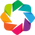

In [4]:
### Libraries
# Be sure to download these libraries if you don't already have them
%pip install datashader; hvplot; param; holoviews; geoviews; colorcet; openpyxl; xlrd

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datashader, hvplot, param, holoviews as hv
import geoviews as gv
import panel as pn
import colorcet as cc
from colorcet.plotting import swatch, swatches
hv.extension('bokeh', 'matplotlib')
import hvplot.pandas
import pathlib


In [5]:
### Data Set Up

# Read in the data
df_raw_inflation = pd.read_excel('Trimmed Mean PCE Inflation.xlsx')
df_raw_property = pd.read_excel('document (79).xls')

df_cleandata = df_raw_property[["Tax Year", "County Name", "Entity Name", "750 Tax_Rate_Real", "750 Tax_Rate_PP", "233b Total_Real", "233b Total_PP", "233b Total_CA"]]

# Initialize Global Lists and Variables

entities = df_cleandata['Entity Name'].unique().tolist()
years = df_cleandata["Tax Year"].unique().tolist()

adjustment_factor= 1000000
rate_growth_cap = 10

# Calculate Base Revenue
df_cleandata['base_total_property'] = df_cleandata["233b Total_Real"] + df_cleandata["233b Total_CA"] # + df_cleandata["233b Total_PP"] 

df_cleandata['base_real_revenue'] = (df_cleandata['750 Tax_Rate_Real']/ adjustment_factor)* df_cleandata['233b Total_Real']
#df_cleandata['base_pp_revenue'] = df_cleandata['750 Tax_Rate_PP']* df_cleandata['233b Total_PP']
df_cleandata['base_ca_revenue'] = (df_cleandata['750 Tax_Rate_Real']/ adjustment_factor)* df_cleandata['233b Total_CA']
df_cleandata['base_total_revenue'] = df_cleandata['base_real_revenue'] + df_cleandata['base_ca_revenue'] # + df_cleandata['base_pp_revenue'] 


### Compute Statewide variables

variables = df_cleandata.columns.to_list()
variables = variables[5:]

df_cleandata['entity_code']=df_cleandata['Entity Name'].str[0:4]
df_cleandata['entity_code']=df_cleandata['entity_code'].astype(int)

df_cleandata['Entity Name'] = df_cleandata['Entity Name'].str[5:]


for year in years:
    df_cleandata.loc[-1]= [year, "99-STATEWIDE", "9999-STATEWIDE", 0, 0, 
                        0, 0, 0, 0, 0, 0, 0, 9999]
    
    for variable in variables:

        alpha = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['entity_code'] == 1010 )][variable].sum()

        df_cleandata.loc[[-1],[variable]] = alpha

    df_cleandata.index = df_cleandata.index + 1



df_cleandata = df_cleandata.merge(df_raw_inflation, how='left', on="Tax Year")


# inflation_rate_forwardlag for trimmed mean annual PCE inflation
# inflation_rate_rolling for 5-year rolling average of CPI for urban less food and energy

df_cleandata['inflation_rate_forwardlag'] = (df_cleandata['inflation_rate_forwardlag']/100) + 1

entities = df_cleandata['Entity Name'].unique().tolist()

#Set up colors and colormaping
highlight = '#196B24'
alt_highlight ='#8b4aa8'

base_colors = ['#196B24', '#8b4aa8', '#767167', '#bcb4a5', '#171615',  '#2f2d29', '#47443e', '#5e5a52', '#8d877c', '#a59e90', '#d4cbb9', '#ebe1ce']
swatch(name= 'base_colors', cmap = base_colors)

C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\2909611739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleandata['base_total_property'] = df_cleandata["233b Total_Real"] + df_cleandata["233b Total_CA"] # + df_cleandata["233b Total_PP"]
C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\2909611739.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleandata['base_real_revenue'] = (df_cleandata['750 Tax_Rate_Real']/ adjustment_factor)* df_cleandata['233b Total_Real']
C:\Users\jarhe\AppData\L

:Image   [x,y]   (z)

In [6]:
# Inflate Revenue 
# real property 
for year in years:
    for entity in entities:
        if year == 2015:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["base_real_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_real_revenue"] = gamma
        
        if year >= 2016:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year - 1) & (df_cleandata['Entity Name']== entity)]["direct-inflated_real_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_real_revenue"] = gamma

# personal property 
'''
for year in years:
    for entity in entities:
        if year == 2015:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["base_pp_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_pp_revenue"] = gamma
        
        if year >= 2016:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year - 1) & (df_cleandata['Entity Name']== entity)]["direct-inflated_pp_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_pp_revenue"] = gamma
'''

# Cenrally Assesed property 
for year in years:
    for entity in entities:
        if year == 2015:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["base_ca_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_ca_revenue"] = gamma
        
        if year >= 2016:
            gamma = df_cleandata.loc[(df_cleandata["Tax Year"] == year - 1) & (df_cleandata['Entity Name']== entity)]["direct-inflated_ca_revenue"].sum() * df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["inflation_rate_forwardlag"].sum()
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"direct-inflated_ca_revenue"] = gamma



In [7]:
# Compute direct-inflated differential
df_cleandata['direct-inflated_diff_real'] = df_cleandata['direct-inflated_real_revenue']- df_cleandata['base_real_revenue']
#df_cleandata['direct-inflated_diff_pp'] = df_cleandata['direct-inflated_pp_revenue']- df_cleandata['base_pp_revenue']
df_cleandata['direct-inflated_diff_ca'] = df_cleandata['direct-inflated_ca_revenue']- df_cleandata['base_ca_revenue']

df_cleandata['direct-inflated_total_revenue'] = df_cleandata['direct-inflated_real_revenue'] + df_cleandata['direct-inflated_ca_revenue'] # + df_cleandata['direct-inflated_diff_pp']
df_cleandata['direct-inflated_diff_total'] = df_cleandata['direct-inflated_total_revenue']- df_cleandata['base_total_revenue']


In [8]:
# Compute Observed Growth Rates
for year in years:
    for entity in entities:
        if year == 2014:
            df_cleandata['observed_growth_rate'] = 0
        
        if year >= 2015:
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),'observed_growth_rate'] = ((df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["base_total_revenue"].sum()/df_cleandata.loc[(df_cleandata["Tax Year"] == year -1) & (df_cleandata['Entity Name']== entity)]["base_total_revenue"].sum())-1)*100

df_cleandata['inflation_rate'] = (df_cleandata['inflation_rate_forwardlag']-1)*100

C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\1135464979.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.6577997239117614' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),'observed_growth_rate'] = ((df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["base_total_revenue"].sum()/df_cleandata.loc[(df_cleandata["Tax Year"] == year -1) & (df_cleandata['Entity Name']== entity)]["base_total_revenue"].sum())-1)*100
C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\1135464979.py:8: RuntimeWarning: invalid value encountered in scalar divide
  df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),'observed_growth_rate'] = ((df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['E

In [9]:
# Capped growth scenario

# compounded 10% growth of total revenue
df_cleandata['10-growth_total_revenue'] = df_cleandata['base_total_revenue']

for year in years:
    for entity in entities:
        
        if year >= 2015:
            delta = df_cleandata.loc[(df_cleandata["Tax Year"] == year- 1 ) & (df_cleandata['Entity Name']== entity)]["10-growth_total_revenue"].sum() * ((rate_growth_cap/100)+1)
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"10-growth_total_revenue"] = delta

# Capped growth rate
df_cleandata["cap_growth_rate"] = df_cleandata['observed_growth_rate']

for year in years:
    for entity in entities:
        if df_cleandata.loc[(df_cleandata["Tax Year"] == year ) & (df_cleandata['Entity Name']== entity)]["observed_growth_rate"].sum() > rate_growth_cap:
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"cap_growth_rate"] = rate_growth_cap

# Capped growth total revenue
df_cleandata['cap-growth_total_revenue'] = df_cleandata['base_total_revenue']

for year in years:
    for entity in entities:
        if year == 2015:
            zeta = df_cleandata.loc[(df_cleandata["Tax Year"] == year- 1 ) & (df_cleandata['Entity Name']== entity)]["base_total_revenue"].sum() * ((df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["cap_growth_rate"].sum()/100)+1)
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"cap-growth_total_revenue"] = zeta
        
        if year >= 2016:
            zeta = df_cleandata.loc[(df_cleandata["Tax Year"] == year- 1 ) & (df_cleandata['Entity Name']== entity)]["cap-growth_total_revenue"].sum() * ((df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity)]["cap_growth_rate"].sum()/100)+1)
            df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"cap-growth_total_revenue"] = zeta


# Capped growth tax rates
for year in years:
    for entity in entities:
        eta = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['cap-growth_total_revenue'].sum()/ (df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['base_total_property'].sum()/ adjustment_factor)
        df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata['Entity Name']== entity),"cap-growth_tax_rate"] = eta


C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\2424120328.py:38: RuntimeWarning: invalid value encountered in scalar divide
  eta = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['cap-growth_total_revenue'].sum()/ (df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['base_total_property'].sum()/ adjustment_factor)
C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\2424120328.py:38: RuntimeWarning: invalid value encountered in scalar divide
  eta = df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['cap-growth_total_revenue'].sum()/ (df_cleandata.loc[(df_cleandata["Tax Year"] == year) & (df_cleandata["Entity Name"]== entity)]['base_total_property'].sum()/ adjustment_factor)
C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\2424120328.py:38: RuntimeWarning: invalid value encountered in scalar divide
  eta = df_cleandata.loc[(df_cleandata["Tax Year"] == yea

In [10]:
# Compute direct-inflated tax rates
df_cleandata['inflated_eff_tax_rate'] = df_cleandata['direct-inflated_total_revenue']/(df_cleandata['base_total_property']/ adjustment_factor)

In [11]:
# Transform Data to a 'reactive object'. 
    # This sets up the interativity with widgets
df_working = pn.rx(df_cleandata)


In [12]:
### Set Up Widgets

entites = df_cleandata['Entity Name'].unique().tolist()
tax_year_widget = pn.widgets.EditableIntSlider(name = 'Tax Year', fixed_start= 2014, fixed_end = 2024, step = 1, value = 2024 )

# Widgets

entitiy_widget = pn.widgets.AutocompleteInput(name = "Entitiy", options = entites, case_sensitive = False, value = 'BEAVER')



# Page Buttons. 
    #These are special widgets which are keyed to the mapping in the 'Build App Layout' chunk. If you change things here, make sure they will still match up with what appears there.
page1_button = pn.widgets.Button(name = "Revenue Comparison", 
                                     icon = 'home', 
                                     icon_size = '24px', 
                                     height = 50, 
                                     styles={"width": "100%", "border-style": "outset"})

page2_button = pn.widgets.Button(name = 'Growth Rate Comparison', 
                                         icon = 'file-info', 
                                         icon_size = '24px', 
                                         height = 50, 
                                         styles={"width": "100%", "border-style": "outset"})

page3_button = pn.widgets.Button(name = "Tax Rate Comparison",
                                          icon = 'layers-difference', 
                                          icon_size = '24px', 
                                          height = 50, 
                                          styles={"width": "100%", "border-style": "outset"})






In [13]:
### Build Interative Objects

# Revenue timeseries
revenue_timeseries = df_working[df_working['Entity Name'] == entitiy_widget].hvplot.line(
    title = 'Property Tax Revenue',
    x = 'Tax Year',
    y = ['base_total_revenue', 'direct-inflated_total_revenue', 'cap-growth_total_revenue'],
    ylabel = "Total Revenue (M)",
    xlabel = "Tax Year",
    color = base_colors,
    line_width = 5,
    line_dash = ['solid','dashed', 'dotted'],
    fontsize={
        'title': 20,
        'xlabel': 16,
        'ylabel': 16,
        'xticks': 16,
        'yticks': 16,
        'legend': 16
    },
    responsive = True)

# Growth Rate timeseries
growth_rate_timeseries = df_working[df_working['Entity Name'] == entitiy_widget].hvplot.line(
    title = 'Growth Rates',
    x = 'Tax Year',
    y = ['observed_growth_rate', 'inflation_rate', 'cap_growth_rate'],
    ylabel = "Growth Rate (%)",
    xlabel = "Tax Year",
    color = base_colors,
    line_width = 5,
    line_dash = ['solid','dashed', 'dotted'],
    fontsize={
        'title': 20,
        'xlabel': 16,
        'ylabel': 16,
        'xticks': 16,
        'yticks': 16,
        'legend': 16
    },
    responsive = True)

# Tax Rate timeseries
tax_rate_timeseries = df_working[df_working['Entity Name'] == entitiy_widget].hvplot.line(
    title = 'Tax Rates',
    x = 'Tax Year',
    y = ['750 Tax_Rate_Real', 'inflated_eff_tax_rate', 'cap-growth_tax_rate'],
    ylabel = "Tax Rate",
    xlabel = "Tax Year",
    color = base_colors,
    line_width = 5,
    line_dash = ['solid','dashed', 'dotted'],
    fontsize={
        'title': 20,
        'xlabel': 16,
        'ylabel': 16,
        'xticks': 16,
        'yticks': 16,
        'legend': 16
    },
    responsive = True)


# Indicators
indicator_growth_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget), 'observed_growth_rate'].mean()
indicator_inflation_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget), 'inflation_rate'].mean()
indicator_cap_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget), 'cap_growth_rate'].mean()

indicator_base_revenue = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), 'base_total_revenue'].max()
indicator_inf_revenue = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), 'direct-inflated_total_revenue'].max()
indicator_cap_revenue = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), 'cap-growth_total_revenue'].max()

indicator_tax_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), '750 Tax_Rate_Real'].max()
indicator_inf_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), 'inflated_eff_tax_rate'].max()
indicator_cap_rate = df_working.loc[(df_working["Entity Name"] == entitiy_widget) & (df_working['Tax Year'] == tax_year_widget), 'cap-growth_tax_rate'].max()



In [14]:
### Build Panes
indicators_revenue = pn.Column(
    pn.Card(pn.indicators.Number(value = indicator_base_revenue, format = '{value:.3f}'), title = 'Base Revenue'),
    pn.Card(pn.indicators.Number(value = indicator_inf_revenue, format = '{value:.3f}'), title = 'Inflated Revenue'),
    pn.Card(pn.indicators.Number(value = indicator_cap_revenue, format = '{value:.3f}'), title = 'Capped Revenue'),
)
indicators_growth = pn.Column(
    pn.Card(pn.indicators.Number(value = indicator_growth_rate, format = '{value:.3f}%'), title = 'Average Growth Rate'),
    pn.Card(pn.indicators.Number(value = indicator_inflation_rate, format = '{value:.3f}%'), title = 'Average Inflation Rate'),
    pn.Card(pn.indicators.Number(value = indicator_cap_rate, format = '{value:.3f}%'), title = 'Average Capped Growth'),
)

indicators_rate = pn.Column(
    pn.Card(pn.indicators.Number(value = indicator_tax_rate, format = '{value:.5f}'), title = 'Tax Rate'),
    pn.Card(pn.indicators.Number(value = indicator_inf_rate, format = '{value:.5f}'), title = 'Tax Rate, Inflated'),
    pn.Card(pn.indicators.Number(value = indicator_cap_rate, format = '{value:.5f}'), title = 'Tax Rate, Capped')
    )

In [15]:
### Build App Layout 
# Build Panes

# Page Switching Function
def show_page(page_key):
    main_area.clear()
    main_area.append(mapping[page_key])

# Initalize Button Connections
    # These tell the app to 'watch' the button clicks and to trigger the page switching function accordingly.
page1_button.on_click(lambda event: show_page("page1"))
page2_button.on_click(lambda event: show_page("page2"))
page3_button.on_click(lambda event: show_page("page3"))

# Create pages
    # These functions determine what shows up on each page. After creating your interative objects, put those objects in the functions below in the matter you would like them to show up.
    # This part can take some faffing to get right so do expiriment with different layouts and panel object types.
def createpage_page1():
    return pn.Column(pn.Row(pn.Column(entitiy_widget, tax_year_widget, indicators_revenue),
                    pn.Card(pn.pane.HoloViews(revenue_timeseries))))

def createpage_page2():
    return pn.Column(pn.Row(pn.Column(entitiy_widget, tax_year_widget, indicators_growth),
                    pn.Card(pn.pane.HoloViews(growth_rate_timeseries))))

def createpage_page3():
    return pn.Column(pn.Row(pn.Column(entitiy_widget, tax_year_widget, indicators_rate),
                    pn.Card(pn.pane.HoloViews(tax_rate_timeseries))))


# Set up page mapping
    # This is the connective tissue that links the button connections to the appropraite page creating function.
    # If more pages are desired, be sure to build another button widget for the page, a lamda event to watch that button, a page creation fucntion to call on button press, and a new item in the dictionary below to link it all together.  
mapping = {
    "page1": createpage_page1(),
    "page2": createpage_page2(),
    "page3": createpage_page3(),
}



# Set up page chunks
    # This is where the app is actually built. It takes everything that has been created above and strings it together into a servable application.

    # 'main_area' sets the default page to land on when the app is spun up.
main_area = pn.Column(mapping["page1"], styles={"width":"100%"})

    # sidebar_default' creates a sidebar object to house all the buttons for switching between pages
sidebar_default = pn.Column(pn.pane.PNG("LFA Logo w text.png", width = 250, height = 100, align = ('center', 'center')), 
                    #pn.pane.Markdown("# Pages", align = ('center', 'center')),  
                    page1_button, 
                    page2_button, 
                    page3_button, 
                    styles={"width": "100%", "padding": "15px"})

# Initalize template
pn.extension(design = 'material')

template = pn.template.MaterialTemplate(
    title = 'Truth in Taxation: Inflation Modeling',
    header_background = 'Black',
    logo = "LFA Logo.png",
    sidebar = [sidebar_default],
    sidebar_width = 400,
    main = [main_area]
)

template.show()

C:\Users\jarhe\AppData\Local\Temp\ipykernel_13816\3475862904.py:57: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension(design = 'material')


Launching server at http://localhost:56350
